# Subspace Inference Based Uncertainty Analysis for Deep Neural Networks 

A non linear system is generally modelled by using many methods and machine learning is one of them. In machine learning based system modelling. The machine learning based algorithm generates model from known dataset known as training data and then can process additional data to make predictions. There are different models used in machine learning systems. Artificial neural networks is a prominant method used in machine learning and it mimics biological neural networks. Similar to real neuron, ANN model contains artificial neurons with parameters. This parameters are adjusted during training or learning process based on sample data for prediction.



The Deep Neural Networks(DNN) is belongs to broader category of ANN with more hidden layers to extract more features from the training data apable to tackle more and more complex and challenging problems. The during training all parameters of DNN will be updated based on loss function. The final trained DNN will be able to predict output similar to actual output for a certain input. However, the different training identifies slightly different DNN paramters for same scenario. This cause an uncertainty in prediction.

The uncertainty in DNN is can be generated using Bayesian inference and it helps to identfy the paramter values that generated likelihood prediction to the acutal output. This identification of uncertainities in deep learning models are called as Bayesian Neural Networks(BNN). 

![Bayes Theorem](img/bayes.png)


Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a posterior hypothesis as more evidence or information becomes available.  Bayes inference derives posteriror probability from the prior probability distributions and the likelihood function that represents the system model. Bayesian inference computes the posterior probability as figure below. In this equation the the posteror probability P(A|B) is proportional to the product of prior and the likelihood probability distribution. P(A|B) and P(B|A) is also called as conditional probability and P(A) and P(B) is called marginal probability. the calculation of P(B) is tedious process, approximate Bayesian inference is introduced. In approximate Bayesian inference, the posterior probability will be proportional to the product of prior probability distribution and the likelihood distribution. Similarly, the prior probability will be proportional to joint probability. The Markov Chain Monte Carlo(MCMC) methods or sing variational inference methods(VI) are used used to sample from posterior distribution by considering the joint probability distribution. The [Turing.jl](https://github.com/TuringLang/Turing.jl) packahe in julia supports Bayesian inference using MCMC methods like MH, HMC and NUTS. Also it supports ADVI inference too. The packages like [AdvancedMH.jl](https://github.com/TuringLang/AdvancedMH.jl) and [AdvanceHMC.jl](https://github.com/TuringLang/AdvancedHMC.jl) are able to posterior samples using Metropolis Hastings and Hamiltonian Monte Carlo algorithm respectively. Moreover, these algorithms are able to take input from user defined probability density functions for inference. The Bayesian inference generates parameter samples within the uncertainty distribution and it is possible to identify the distribution of sample using ststistical methods. The BNN paramters as a distribution is illustrated in figure below:

![BNN](img/bnn.png)

The drawback on BNN is the time to generate the inference. When the number of parameters in the NN increses, the uncertainty genertaion of NN parameters using Bayesian concept become more expensive in terms of time. 

Subspace inference method introduced to reduce the inference time in BNN by constructing a smaller subspace of actual NN paramter space. This subspace is generated from principle components of deviation marix of weight updation during training. 

### Subspace Inference Algorithm

The subspace inference uses a pretrained DNN and it is implemented using following steps

1. Generate low dimensional subspace
2. Execute Bayesian inference within this subspace
3. Transform posterior of lower dimensional subspace to original dimension

#### Algorithm for subspace construction
The subspace of NN model paramters are constructed by following steps:
1. Initialize mean parameters to pretrained parameter value, `Wswa = W0`
2. For eavery epoch `i` 
    2.1 Update parameter using SGD
    2.2 Update mean parameters as  `Wswa = (n*Wswa + wi)/(n+1)`, where `n = i/f`. `f` is the weight update frequency
    2.3 Calculate parameter deviation, `Wd = Wi-Wswa`
3. Do principle component analysis
4. Generate projection marix

### Improvements in Subspace Inference
The subspace inference implementation by [Izamailov](https://arxiv.org/abs/1907.07504) consider deviations of last `M ` (rank of PCA) columns. We have modified this by considering all deviation matrix during subspace construction to get more information about the subspace. Moreover, in that work, the posterior of subspace is updated based prior distribution of subspace only. We modified to generate subspace samples based on weight distribtuion. The prior distribution is defined as function and it inputs subspace and outputs the prior distribution of weigth parameters of NN like below:
```
function prior(z)
    W = Wswa + Pz
    return Normal(W,1.0)
end
```
The advanced MH and HMC algorithms help to take prior as functions instead of distribution.


The subspace inference method for NN is implemeted as a package named [SubspaceInference.jl](https://github.com/efmanu/SubspaceInference.jl) in Julia and it can be installed as below:


In [1]:
# using Pkg
# Pkg.add("https://github.com/efmanu/SubspaceInference.jl")

### Example for subspace inference for DNN
To implemet this example, we use a multilayer perceptron with 2 input and one output  and 3 hidden layers. This example uses the data and the model from [python implementation](https://github.com/wjmaddox/drbayes). 

### use packages

In [2]:
#use packages

using NPZ
using Plots
using Flux
using Flux: Data.DataLoader
using Flux: @epochs
using Plots
using BSON: @save
using BSON: @load
using Zygote
using Statistics
using Revise
using SubspaceInference;

### Set working directory

In [3]:
root = pwd();
cd(root);

### Plot Data
This loaded data conatains two columns, one is taken as x and y. The x is converted to features using features function. Then zipped using DataLoader available with Flux

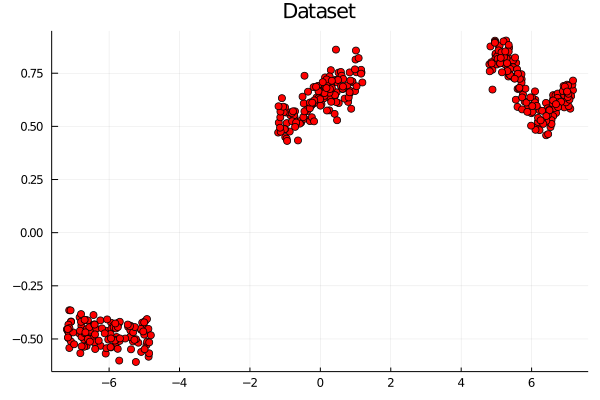

In [4]:
#laod data
data_ld = npzread("data.npy");
x, y = (data_ld[:, 1]', data_ld[:, 2]');
function features(x)
    return vcat(x./2, (x./2).^2)
end

f = features(x);
data =  DataLoader(f,y, batchsize=50, shuffle=true);

#plot data
scatter(data_ld[:,1],data_ld[:,2],color=["red"], title="Dataset", legend=false)

### DNN Model setup
The simple multilayer perceptron is created as using Dense layer. This DNN contains 2 inputs, 1 output and hidden layers of `[200,50,50]` size. All layers other than the output layer contains the ReLu activation function.

In [5]:
m = Chain(
    Dense(2,200,Flux.relu), 
    Dense(200,50,Flux.relu),
    Dense(50,50,Flux.relu),
    Dense(50,50,Flux.relu),
    Dense(50,1),
);

The model is destructed to extract weights and function as below

In [6]:
θ, re = Flux.destructure(m);

### Cost function
Gaussian likelihood cost function is implemented for training as:

In [7]:
L(m, x, y) = Flux.Losses.mse(m(x), y)/2;

The parameters are loaded as:

In [8]:
ps = Flux.params(m);

### Optimizer
The optimizer used in this project is Stochastic gradient descent with momentum value:

In [9]:
opt = Momentum(0.01, 0.95);

### Pretrain weights ad save
The DNN needs to pre-train and save for subspace inference as below. NB: training takes little time. This package examples contain some trained weights.

In [10]:
# epochs = 3000
# for j in 1:5
#    m = Chain(
#            Dense(2,200,Flux.relu),
#            Dense(200,50,Flux.relu),
#            Dense(50,50,Flux.relu),
#            Dense(50,50,Flux.relu),
#            Dense(50,1),
#    )
#    ps = Flux.params(m)
#    SubspaceInference.pretrain(epochs, L, ps, data, opt, lr_init =0.01, print_freq= 100)
#    @save "model_weights_$(j).bson" ps
# end

### Plot different SGD solutions
This SGD solutions are used as the standard to compare the uncertainties generated by using subspace inference

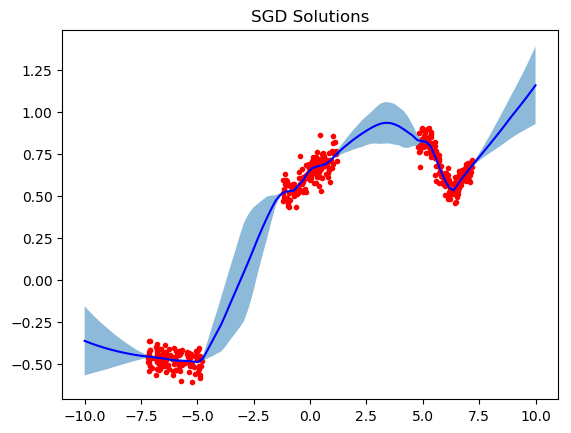

In [12]:
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,5)
for i in 1:5
	@load "model_weights_$(i).bson" ps
	Flux.loadparams!(m, ps)
	out = m(inp)
	trajectories[:, i] = out'
end
all_trj = Dict()
all_trj["1"] = trajectories
SubspaceInference.plot_predictive(data_ld, all_trj, z, title=["SGD Solutions"]);

### Load pre-trained weight
The pre-trained weights can be found in the examples folder.

In [13]:
i = 1;
@load "model_weights_$(i).bson" ps;
Flux.loadparams!(m, ps);

### Generate uncertainty of weights using
The weight_uncertainty function from the SubspaceInference package is used to generate parameter space uncertainty.

In [26]:
M = 5 #Rank of PCA or Maximum columns in deviation matrix
T = 1 #Steps
itr = 100
all_chain, lp, W_swa = subspace_inference(m, L, data, opt,
	σ_z = 0.1,	itr =itr, T=T, c=1, M=M, print_freq=T, alg =:rwmh);


Traing loss: 0.00094632316080836 Epoch: 1

Sampling:  29%|████████████                             |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


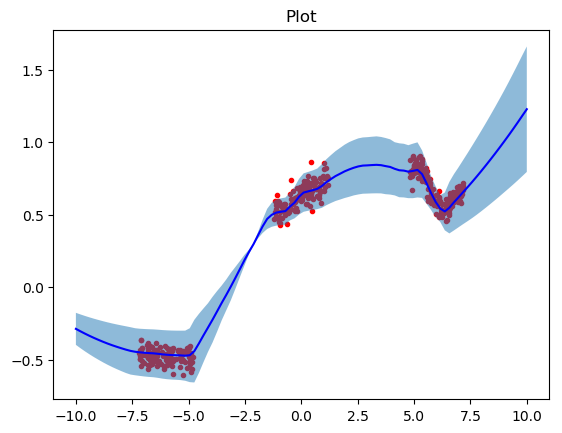

In [27]:
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[i])
	out = m1(inp)
	trajectories[:, i] = out'
end
all_trajectories = Dict()
all_trajectories["1"] = trajectories;

SubspaceInference.plot_predictive(data_ld, all_trajectories, z, title=["Plot"])

### Effect of comparison of different subspace sizes

This simulation considers subspace size of 3,5 and 10.

Traing loss: 0.0009328829244574521 Epoch: 5


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Traing loss: 0.0018656734982915512 Epoch: 5


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Traing loss: 0.0011516806220339415 Epoch: 5


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Traing loss: 0.001302420306495211 Epoch: 5


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


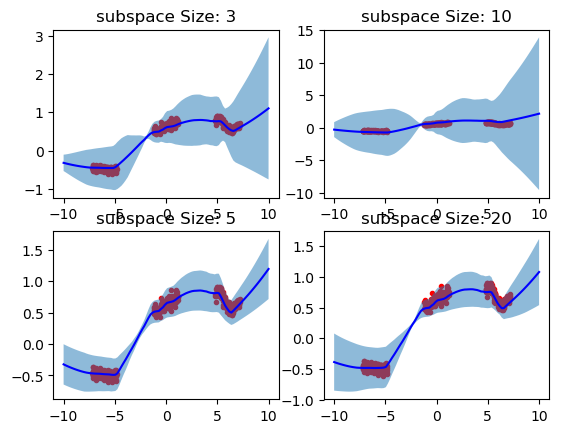

In [44]:


M = [3, 5, 10, 20] #Rank of PCA or Maximum columns in deviation matrix
T = 5 #Steps
itr = 100
all_trajectories = Dict()
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
for mi in 1:4
    i = 1;
    @load "model_weights_$(i).bson" ps;
    Flux.loadparams!(m, ps);
    all_chain, lp, W_swa = subspace_inference(m, L, data, opt,
	σ_z = 1.0,	itr =itr, T=T, c=1, M=M[mi], print_freq=T, alg =:rwmh);    
    
    trajectories = Array{Float64}(undef,100,itr)
    for i in 1:itr
        m1 = re(all_chain[i])
        out = m1(inp)
        trajectories[:, i] = out'
    end
    all_trajectories["$(mi)"] = trajectories;
end
title = ["subspace Size: 3","subspace Size: 5","subspace Size: 10","subspace Size: 20"]

SubspaceInference.plot_predictive(data_ld, all_trajectories, z, title=title)

### Analysis of proposal standard deviation in uncertainty generation

This simulation considers subspace standard deviations of 0.1 and 1.0.

Traing loss: 0.001384325128779116 Epoch: 5


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Traing loss: 0.0012711838564104384 Epoch: 5


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


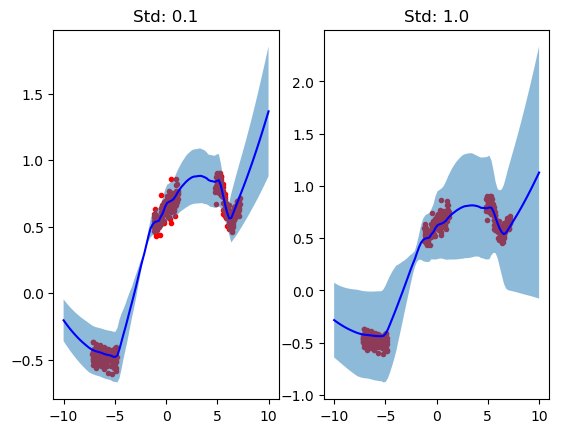

In [48]:
M = 10 #Rank of PCA or Maximum columns in deviation matrix
T = 5 #Steps
itr = 100
all_trajectories = Dict()
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
σ_z = [0.1, 1.0]
for mi in 1:2
    i = 1;
    @load "model_weights_$(i).bson" ps;
    Flux.loadparams!(m, ps);
    all_chain, lp, W_swa = subspace_inference(m, L, data, opt,
	σ_z = σ_z[mi],	itr =itr, T=T, c=1, M=M, print_freq=T, alg =:rwmh);    
    
    trajectories = Array{Float64}(undef,100,itr)
    for i in 1:itr
        m1 = re(all_chain[i])
        out = m1(inp)
        trajectories[:, i] = out'
    end
    all_trajectories["$(mi)"] = trajectories;
end
title = ["Std: 0.1", "Std: 1.0"]

SubspaceInference.plot_predictive(data_ld, all_trajectories, z, title=title)